<h1>¿Podemos predecir las cancelaciones?</h1>

In [1]:
#Importar librerias
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import modulo_conn_sql as mcq
from io import BytesIO

# Importar Keras y librerias adicionales
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBClassifier

import pickle

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [2]:
#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

In [4]:
#Dataset de los despachos
df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?)}" , (pais, dias) )
df_serv = df_serv.fillna(value=np.nan)
df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')
df_serv.head()

,Pedido,servicio,Entrega,Estatus,EstatusPedido,Cluster,Planta,Ciudad,Centro,Obra,...,DistanciaPlantaObraKm,Cumplimiento,AceptacionOrdenes,TiempoObra,VolEntregado,CancelacionCliente,CancelacionCemex,CancelacionOtros,TipoObra,year_month
0,8008520411,L013,,Normal,Completada - Cabecera,CLUSTER CENTRO,CO-PLANTA PUENTE ARANDA,Bogotá,F069,66487820,...,9.552235,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Normal,2019-04
1,8008519752,L005,,Normal,En proceso - Cabecera,CLUSTER CENTRO,CO-PLANTA SUR (DTE),Bogotá,F006,66569681,...,9.185977,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Normal,2019-04
2,8008524182-S,L003,,Normal,En proceso - Cabecera,CLUSTER CENTRO,CO-PLANTA PUENTE ARANDA,Bogotá,F048,66636935,...,7.578517,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Normal,2019-04
3,8008517484,L001,,Normal,Cancelada - Cabecera,CLUSTER CENTRO,CO-PLANTA SIBERIA,Bogotá,F058,66608857,...,5.709090,NaN,1.0,NaN,0.0,0.0,0.0,7.0,Normal,2019-04
4,8008517484,L002,,Normal,Cancelada - Cabecera,CLUSTER CENTRO,CO-PLANTA SIBERIA,Bogotá,F058,66608857,...,5.709090,NaN,NaN,NaN,0.0,0.0,0.0,7.0,Normal,2019-04


In [ ]:
df_serv.describe()

In [5]:
#Dataset de la programación
df_pedidos = querySQL( "{CALL SCAC_AP11_Dataset_Pedidos (?,?)}" , (pais, dias) )
df_pedidos = df_pedidos.fillna(value=np.nan)
df_pedidos['year_month'] = df_pedidos.FechaEntrega.dt.to_period('M')
df_pedidos.head()

,Obra,Pedido,FechaEntrega,CreadoEl,Ciudad,TipoProducto,Tremie,Outinord,Elemento,Cimentacion,...,TipoObra,diasCreado,VolPartida,AceptacionOrdenes,latitud,longitud,Bomba,PedidoCancelado,VolCanceladoCliente,year_month
0,66520322,8007794652-S,2019-01-01,2018-10-04 12:26:06,Barranquilla,Convencional,0,0,CIMENTACI+N,0,...,Normal,31,0.25,1,10.976720,-74.842648,0,1,0.25,2019-01
1,66337255,8008147021,2019-01-02,2018-12-27 08:49:36,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,Normal,7,8.00,1,10.925068,-74.880914,0,1,8.00,2019-01
2,66337255,8008147022,2019-01-02,2018-12-27 08:51:01,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,Normal,7,8.00,1,10.925068,-74.880914,0,1,0.00,2019-01
3,66337255,8008147023,2019-01-02,2018-12-27 08:51:03,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,Normal,7,8.00,1,10.925068,-74.880914,0,1,0.00,2019-01
4,66337255,8008157514-S,2019-01-02,2018-12-31 15:16:13,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,Normal,3,4.00,1,10.925068,-74.880914,0,0,0.00,2019-01


In [ ]:
df_pedidos.describe()

In [ ]:
df_pedidos.columns

<h3> %Cumplimiento por obra por mes </h3>

In [6]:
df_cumpto = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['Obra', 'year_month'])['Cumplimiento'].agg(['sum','count']).reset_index()
df_cumpto['cumplimiento_mes'] = df_cumpto['sum'] / df_cumpto['count']
df_cumpto = df_cumpto.drop(['sum','count'], axis=1)
df_cumpto.head()

,Obra,year_month,cumplimiento_mes
0,65278858,2019-11,1.000000
1,65278858,2019-12,1.000000
2,65278858,2020-02,1.000000
3,65278858,2020-10,0.666667
4,65278858,2020-11,0.500000


<h3> Tiempo en Obra por obra por mes </h3>

In [7]:
df_to = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Obra'])['TiempoObra'].agg(['mean']).reset_index()
df_to = df_to.rename(columns = {'mean':'tiempo_obra'})
df_to.head()

,year_month,Obra,tiempo_obra
0,2019-01,65279988,49.000000
1,2019-01,65281864,62.166667
2,2019-01,65379578,60.000000
3,2019-01,65401003,55.000000
4,2019-01,65466724,70.385965


<h3> Volumen Entregado Mes Obra </h3>

In [8]:
df_ve = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['year_month','Obra'])['VolPartida'].agg(['sum']).reset_index()
df_ve = df_ve.rename(columns = {'sum':'volumen_entregado'})
df_ve.head()

,year_month,Obra,volumen_entregado
0,2019-01,65279988,7.50
1,2019-01,65281864,24.50
2,2019-01,65379578,10.50
3,2019-01,65401003,15.00
4,2019-01,65466724,352.75


<h3> Aceptación de Órdenes por obra por mes </h3>

In [9]:
df_ao = df_pedidos.groupby(['year_month','Obra'])['AceptacionOrdenes'].agg(['sum', 'count']).reset_index()
df_ao['AO'] = df_ao['sum']/df_ao['count']
df_ao = df_ao.drop(['sum','count'], axis= 1)
df_ao.head()

,year_month,Obra,AO
0,2019-01,65279988,0.000000
1,2019-01,65281864,0.800000
2,2019-01,65379578,0.500000
3,2019-01,65401003,0.333333
4,2019-01,65410312,0.000000


<h3> Cancelación motivo cliente - obra por mes</h3>

In [10]:
df_canc = pd.pivot_table(
    df_pedidos,
    index = ['year_month', 'Obra'],
    values = ['VolCanceladoCliente', 'VolPartida'],
    aggfunc = np.sum
)
df_canc = df_canc.reset_index()
df_canc['cancelacionCliente'] =df_canc['VolCanceladoCliente']/df_canc['VolPartida']
df_canc = df_canc.drop(['VolCanceladoCliente', 'VolPartida'], axis= 1)
df_canc.head()

,year_month,Obra,cancelacionCliente
0,2019-01,65279988,0.000000
1,2019-01,65281864,0.196721
2,2019-01,65379578,0.000000
3,2019-01,65401003,0.000000
4,2019-01,65410312,1.000000


<h2> Productividad Programación  </h2>
<hr>
<b> productividad habitual</b>
<p> Volumen Entregado Mes / #Pedidos Mes(Pedidos No Cancelados) ej. Obra Edificio x: 15m3 por pedido </p>

<b>productividad día</b>
<p> Volumen Entregado Dia / #Pedidos Dia(Todos los pedidos) ej. Obra Edifico x: 30m3 por pedido</p>

<b> productividad Programación = productividad día / productividad habitual</b>


<h3> Pedidos diarios por obra</h3>

In [11]:
df_pdo = df_pedidos.groupby(['FechaEntrega','Obra'])['Pedido'].agg(['count']).reset_index()
df_pdo.rename(columns={'count':'PedidosDia'}, inplace = True)
df_pdo.head()

,FechaEntrega,Obra,PedidosDia
0,2019-01-01,66520322,1
1,2019-01-01,66528575,1
2,2019-01-02,65658981,1
3,2019-01-02,65784521,1
4,2019-01-02,66026013,1


<h3> Pedidos (No Cancelados) Mensuales por obra</h3>

In [12]:
df_pmo = df_pedidos[df_pedidos['PedidoCancelado'] == 0].groupby(['year_month','Obra'])['Pedido'].agg(['count']).reset_index()
df_pmo.rename(columns={'count':'PedidosMes'}, inplace = True)
df_pmo.head()

,year_month,Obra,PedidosMes
0,2019-01,65279988,1
1,2019-01,65281864,4
2,2019-01,65379578,2
3,2019-01,65401003,3
4,2019-01,65466724,35


<h3> Volumen Entregado Día-Obra </h3>

In [13]:
df_ved = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['FechaEntrega','Obra'])['VolPartida'].agg(['sum']).reset_index()
df_ved = df_ved.rename(columns = {'sum':'volumen_entregado_dia'})
df_ved.head()

,FechaEntrega,Obra,volumen_entregado_dia
0,2019-01-02,65658981,8.25
1,2019-01-02,65784521,7.00
2,2019-01-02,66026013,7.75
3,2019-01-02,66299296,10.00
4,2019-01-02,66309290,12.75


<h3> Se ensamblan los indicadores</h3>

In [14]:
#Se agrega indicador cumplimiento mes obra
df = pd.merge(df_pedidos, df_cumpto, how='left', on=['Obra', 'year_month'] )
#Se agrega indicador Tiempo en obra 
df = pd.merge(df, df_to, how='left', on=['Obra', 'year_month'] )
#Se agrega volumen entregado mes obra 
df = pd.merge(df, df_ve, how='left', on=['Obra', 'year_month'] )
#Se agrega aceptacion de ordenes por obra por mes 
df = pd.merge(df, df_ao, how='left', on=['Obra', 'year_month'] )
#Se agrega cancelacion motivo cliente por obra por mes 
df = pd.merge(df, df_canc, how='left', on=['Obra', 'year_month'] )
#se agrega numero de pedidos (no cancelados) solicitados en el mes 
df = pd.merge(df, df_pmo, how='left', on=['Obra', 'year_month'] )

#se agrega pedidos solicitados por obra por dia
df = pd.merge(df, df_pdo, how='left', on=['Obra', 'FechaEntrega'] )
#se agrega volumen total entregado por obra por dia
df = pd.merge(df, df_ved, how='left', on=['Obra', 'FechaEntrega'] )

#calular productividad programacion diaria
df['productividad_programacion'] =( (df['volumen_entregado_dia'] / df['PedidosDia']) / (df['volumen_entregado']/df['PedidosMes'])).fillna(0)

df.head(100)

,Obra,Pedido,FechaEntrega,CreadoEl,Ciudad,TipoProducto,Tremie,Outinord,Elemento,Cimentacion,...,year_month,cumplimiento_mes,tiempo_obra,volumen_entregado,AO,cancelacionCliente,PedidosMes,PedidosDia,volumen_entregado_dia,productividad_programacion
0,66520322,8007794652-S,2019-01-01,2018-10-04 12:26:06,Barranquilla,Convencional,0,0,CIMENTACI+N,0,...,2019-01,1.000,NaN,45.0,0.750000,0.005525,7.0,1,NaN,0.000000
1,66337255,8008147021,2019-01-02,2018-12-27 08:49:36,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,2019-01,0.928,57.417391,869.5,0.792746,0.166730,125.0,5,4.0,0.115009
2,66337255,8008147022,2019-01-02,2018-12-27 08:51:01,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,2019-01,0.928,57.417391,869.5,0.792746,0.166730,125.0,5,4.0,0.115009
3,66337255,8008147023,2019-01-02,2018-12-27 08:51:03,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,2019-01,0.928,57.417391,869.5,0.792746,0.166730,125.0,5,4.0,0.115009
4,66337255,8008157514-S,2019-01-02,2018-12-31 15:16:13,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,2019-01,0.928,57.417391,869.5,0.792746,0.166730,125.0,5,4.0,0.115009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,66587963,8008166863-S,2019-01-05,2019-01-04 12:27:31,Barranquilla,Pavimentos,0,0,PAVIMENTOS,0,...,2019-01,1.000,45.500000,49.5,0.857143,0.123894,6.0,1,10.0,1.212121
96,66544963,8008015643-S,2019-01-06,2018-11-23 12:19:42,Barranquilla,Convencional,0,0,COLUMNA,0,...,2019-01,NaN,NaN,NaN,1.000000,1.000000,NaN,1,NaN,0.000000
97,66337255,8008165810,2019-01-08,2019-01-04 09:51:53,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,2019-01,0.928,57.417391,869.5,0.792746,0.166730,125.0,6,33.5,0.802664
98,66337255,8008165814-S,2019-01-08,2019-01-04 09:52:32,Barranquilla,Especiales,0,0,CIMENTACI+N,0,...,2019-01,0.928,57.417391,869.5,0.792746,0.166730,125.0,6,33.5,0.802664


In [ ]:
plt.figure(figsize=(18,15))
sns.violinplot(x='PedidoCancelado', y ='productividad_programacion', data= df)

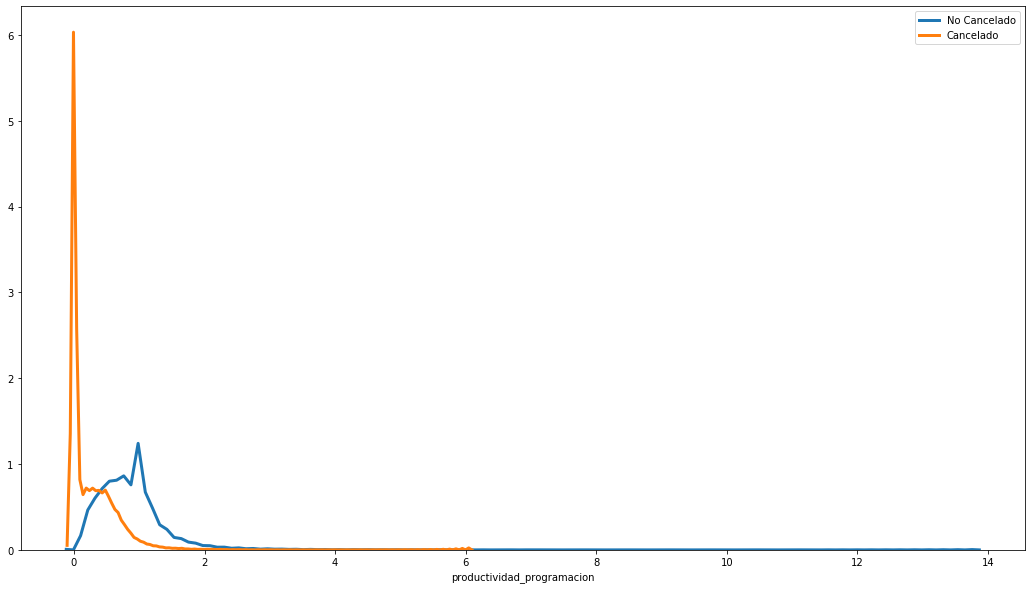

In [31]:
plt.figure(figsize=(18,10))

sns.distplot( df[df['PedidoCancelado']== 0 ]['productividad_programacion'], hist = False, kde = True, kde_kws = {'linewidth': 3},
                 label = 'No Cancelado')

sns.distplot( df[df['PedidoCancelado']== 1 ]['productividad_programacion'], hist = False, kde = True, kde_kws = {'linewidth': 3},
                 label = 'Cancelado')

In [ ]:
#Export to Excel
"""
output = BytesIO()
writer = pd.ExcelWriter(output, engine='xlsxwriter')
writer = pd.ExcelWriter("dataset_train " + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S") + ".xlsx", engine='xlsxwriter')
df.to_excel( writer)
writer.save()
"""

In [15]:
#tomo unicamente las columnas que son variables predictoras y  la columna objetivo (pedido cancelado)
dataset = df[[
    'VolPartida',
    'latitud',
    'longitud',
    'DistanciaPlantaObraKm',
    'HoraEntregaPartida',
    'diasCreado',
    'AceptacionOrdenes',
    'DiaSemana',
    'Semana_Relativa',
    'Tremie',
    'Outinord',
    'Bomba',
    'Cimentacion',
    'cumplimiento_mes',
    'AO',
    'tiempo_obra',
    'cancelacionCliente',
    'volumen_entregado',
    'productividad_programacion',
    'PedidoCancelado'
]]

dataset.head()

,VolPartida,latitud,longitud,DistanciaPlantaObraKm,HoraEntregaPartida,diasCreado,AceptacionOrdenes,DiaSemana,Semana_Relativa,Tremie,Outinord,Bomba,Cimentacion,cumplimiento_mes,AO,tiempo_obra,cancelacionCliente,volumen_entregado,productividad_programacion,PedidoCancelado
0,0.25,10.976720,-74.842648,10.247200,1,31,1,3,1,0,0,0,0,1.000,0.750000,NaN,0.005525,45.0,0.000000,1
1,8.00,10.925068,-74.880914,19.447606,8,7,1,4,1,0,0,0,0,0.928,0.792746,57.417391,0.166730,869.5,0.115009,1
2,8.00,10.925068,-74.880914,19.447606,11,7,1,4,1,0,0,0,0,0.928,0.792746,57.417391,0.166730,869.5,0.115009,1
3,8.00,10.925068,-74.880914,19.447606,14,7,1,4,1,0,0,0,0,0.928,0.792746,57.417391,0.166730,869.5,0.115009,1
4,4.00,10.925068,-74.880914,19.447606,14,3,1,4,1,0,0,0,0,0.928,0.792746,57.417391,0.166730,869.5,0.115009,0


<h2> ---------------------- Entrenamiento de modelos de clasificación ----------------------- </h2>

In [16]:
#definicion de X, y para los modelos de regresion 
X = dataset[[
    'VolPartida',
    'latitud',
    'longitud',
    'DistanciaPlantaObraKm',
    'HoraEntregaPartida',
    'diasCreado',
    'AceptacionOrdenes',
    'DiaSemana',
    'Semana_Relativa',
    'Tremie',
    'Outinord',
    'Bomba',
    'Cimentacion',
    'cumplimiento_mes',
    'AO',
    'tiempo_obra',
    'cancelacionCliente',
    'volumen_entregado',
    'productividad_programacion'
]].fillna(0)

y = dataset[['PedidoCancelado']]

# Dividir el data set en conjunto de entrenamiento y conjunto de testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Escalado de variables
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#Inicializar la RNA
classifier = Sequential()

#añadir capas de entrada y primera capa oculta
classifier.add(Dense(units = 20, kernel_initializer = "random_uniform", activation = "relu", input_dim = 19))

#añadir capa de olvido
classifier.add(Dropout(rate = 0.3))

#añadir segunda capa oculta
classifier.add(Dense(units = 20, kernel_initializer = "random_uniform", activation = "relu"))

#añadir capa de olvido
classifier.add(Dropout(rate = 0.3))

#añadir segunda capa oculta
classifier.add(Dense(units = 20, kernel_initializer = "random_uniform", activation = "relu"))

#añadir capa de olvido
classifier.add(Dropout(rate = 0.3))

#añadir segunda capa oculta
classifier.add(Dense(units = 20, kernel_initializer = "random_uniform", activation = "relu"))

#añadir capa de olvido
classifier.add(Dropout(rate = 0.3))

#añadir segunda capa oculta
classifier.add(Dense(units = 20, kernel_initializer = "random_uniform", activation = "relu"))

#añadir capa de olvido
classifier.add(Dropout(rate = 0.3))

#añadir capa de salida
classifier.add(Dense(units = 1,  kernel_initializer = "random_uniform", activation = "sigmoid"))

#compilar RNA
classifier.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# Ajustar la RNA en el Conjunto de Entrenamiento
classifier.fit(X_train, y_train, batch_size= 1024, epochs = 100)

In [ ]:
# Predicción de los resultados con el Conjunto de Testing
y_pred  = classifier.predict(X_test)
y_pred = (y_pred>=0.80)
y_pred

In [ ]:
# Elaborar una matriz de confusión
cm = confusion_matrix(y_test, y_pred)
cm

<h2> ---------------------- XGBOOST ----------------------- </h2>

In [18]:
classifier_XG = XGBClassifier()

In [ ]:
classifier_XG.fit(X_train, y_train)

In [ ]:
# Predicción de los resultados con el Conjunto de Testing
y_pred2  = classifier_XG.predict(X_test)
y_pred2 = (y_pred2>0.55)
y_test2 = np.array(y_test)
y_test2 = (y_test2 == 1)

# Elaborar una matriz de confusión
cm = confusion_matrix(y_test2, y_pred2)
cm

In [ ]:
for i,var in enumerate(X.columns):
    print(i, var)

In [ ]:
xgb.plot_importance(classifier_XG)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

<b> GridSearch - Params 1 </b>

In [ ]:
param_test1 = {
 'max_depth':range(6,10),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5 )

gsearch1.fit(X_train, y_train)

In [ ]:
gsearch1.cv_results_

In [ ]:
 gsearch1.best_params_

In [ ]:
gsearch1.best_score_

<b> GridSearch - Params 2 </b>

In [19]:
param_test2 = {
 'n_estimators':[500,550,600]
}

In [20]:
gsearch2 = GridSearchCV(estimator = XGBClassifier( 
    learning_rate =0.1, 
    max_depth=9,
    min_child_weight=1, 
    reg_alpha=1,
    gamma=0.1,
    subsample=0.8, 
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=1,
    seed=27 ), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0.1,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=9, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=1, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid=False, n_jobs=4, param_grid={'n_estimators': [500, 550, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [21]:
gsearch2.best_params_

{'n_estimators': 500}

In [22]:
gsearch2.best_score_

0.9407648848667887

<b> Implementando los resultados del GridSearch </b>

In [23]:
classifier_XG_pro = XGBClassifier(    
    learning_rate =0.1, 
    n_estimators=500, 
    max_depth=9,
    min_child_weight=1, 
    gamma=0.1, 
    reg_alpha=1,
    subsample=0.8, 
    colsample_bytree=0.8,
    objective= 'binary:logistic', 
    nthread=4, 
    scale_pos_weight=1,
    seed=27 )
classifier_XG_pro.fit(X_train, y_train)
# Predicción de los resultados con el Conjunto de Testing
y_pred3  = classifier_XG_pro.predict(X_test)
y_test3 = np.array(y_test)
y_test3 = (y_test3 == 1)

In [24]:
# Elaborar una matriz de confusión
cm = confusion_matrix(y_test3, y_pred3)
cm

array([[32843,  1813],
       [ 4020, 14260]], dtype=int64)

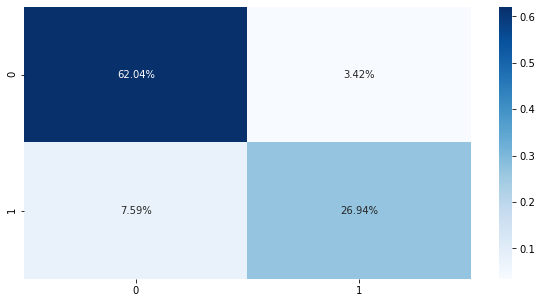

In [25]:
plt.figure(figsize=(10,5))
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [30]:
(cm/np.sum(cm))[1][1]

0.2693818951186338

<b> Guardar modelo para futuros usos </b>

In [27]:
file_name = "xgb_prediccion_cancelaciones_n500.pkl"

# save
pickle.dump(classifier_XG_pro, open(file_name, "wb"))

In [ ]:
#guardar el escalador de variables utilizado en el modelo
from sklearn.externals.joblib import dump, load
dump(sc_X, 'std_scaler.bin', compress=True)

In [ ]:
# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))